In [ ]:
# Import libraries
import pandas as pd
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk 
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Inspect the cleaned csv file
df = pd.read_csv('hotel_reviews_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4091 entries, 0 to 4090
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    4091 non-null   object 
 1   Rating  4091 non-null   float64
 2   Text    4091 non-null   object 
dtypes: float64(1), object(2)
memory usage: 96.0+ KB


## WordCloud Inspection

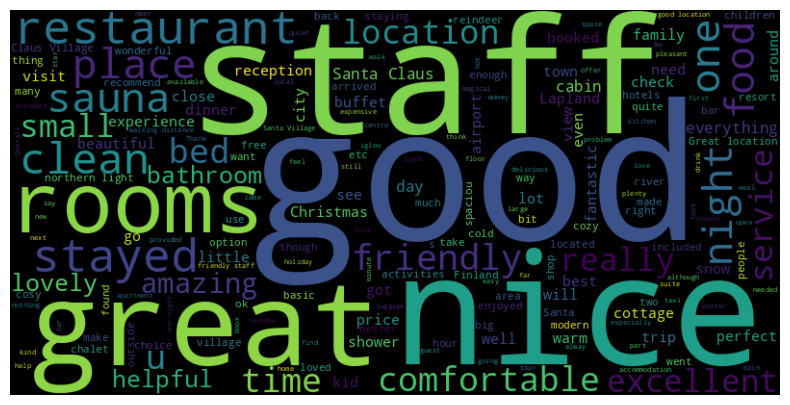

In [ ]:
# Wordcloud inspection for custom stopwords list

# Combine all text into a single string
text = ' '.join(df['Text'])

# Define the stopwords list
my_stopwords = set(STOPWORDS)
my_stopwords.update(['hotel', 'room', 'stay', 'breakfast', 'Rovaniemi']) #these are the most common ones that bring little value


# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, stopwords=my_stopwords, background_color='black').generate(text)

# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
# Calculate the sentiment using TextBlob

# Function to calculate polarity using TextBlob
def calculate_polarity(text):
    testimonial = TextBlob(text)
    return testimonial.sentiment.polarity

# Create a new column 'polarity_score_textblob'
df['polarity_score_textblob'] = df['Text'].apply(calculate_polarity)

# Group by 'Name' and calculate the average 'polarity_score_textblob'
average_polarity = df.groupby('Name')['polarity_score_textblob'].mean().reset_index()

# Sort by highest average_polarity
sorted_average_polarity = average_polarity.sort_values(by='polarity_score_textblob', ascending=False)

# Display the sorted average polarity scores
print(sorted_average_polarity)

                                      Name  polarity_score_textblob
9                        Hotel Metsahirvas                 0.402099
11      Korvala Log Cabins and Husky Tours                 0.398705
2                       Arctic Light Hotel                 0.378916
8                         Hostel Cafe Koti                 0.369598
13           Lapland Hotels Sky Ounasvaara                 0.368974
6                             Glass Resort                 0.353474
7               HAAWE Boutique Apart Hotel                 0.339612
0                            Apukka Resort                 0.337221
5                             Casa Arctica                 0.334953
20                   Ounasvaaran Lakituvat                 0.334281
18                      Nova Skyland Hotel                 0.327665
17      Nordica Design Residence Rovaniemi                 0.315945
14                             LomaVekarit                 0.312664
21             Santa Claus Holiday Village      

In [ ]:
# Calculate the amount of positive and negative reviews on the dataset

# Define the threshold for positive sentiment (ratings 4 or 5)
positive_threshold = 4

# Create a new column 'Sentiment' based on the threshold
df['Sentiment'] = (df['Rating'] >= positive_threshold).astype(int)

# Count the number of positive and negative reviews
positive_reviews = df[df['Sentiment'] == 1].shape[0]
negative_reviews = df[df['Sentiment'] == 0].shape[0]

print(f'Number of Positive Reviews: {positive_reviews}')
print(f'Number of Negative Reviews: {negative_reviews}')

# Find the proportion of positive and negative reviews
print('Proportion of positive and negative reviews: ', df['Sentiment'].value_counts() / len(df))

Number of Positive Reviews: 3350
Number of Negative Reviews: 741
Proportion of positive and negative reviews:  1    0.818871
0    0.181129
Name: Sentiment, dtype: float64


In [ ]:
print(df[['Name', 'Text', 'Sentiment']].head(3))

            Name                                               Text  Sentiment
0  Apukka Resort  Great Winter Wonderland Great Winter Wonderlan...          1
1  Apukka Resort  Fantastic Experience I appreciate that we prob...          1
2  Apukka Resort  Winter wonderland Came here for a get away fro...          1


## Supervised Machine Learning using Bag-of-Words (BoW)

In sentiment analysis, the "Bag of Words" (BoW) model is a fundamental technique used for text representation. It treats a piece of text (like a sentence or a document) as an unordered set of words, ignoring grammar and word order. The basic idea is to convert text data into numerical format that can be used as input for machine learning algorithms.

1. Tokenization: The first step is to break down the text into individual words or tokens. For example, the sentence "I love data mining" would be tokenized into ["I", "love", "data", "mining"].

2. Vocabulary Construction: Next, a vocabulary is created by extracting all unique words from the entire dataset. This forms a dictionary where each word is assigned a unique index or ID.

3.Vectorization: Each document is then represented as a vector of fixed length, equal to the size of the vocabulary. The elements of this vector correspond to the frequency of each word in the document. For example, if the vocabulary has 10,000 words, each document will be represented as a vector of length 10,000, where each element represents the count of a specific word.

For instance, if our vocabulary includes the words ["I", "love", "this", "movie"], and we have a sentence "I love this movie, but the acting was not great", the BoW representation might look like [1, 1, 1, 1, 0, ...] because "I", "love", "this", and "movie" appear once each, and the other words do not appear.

4. Sparse Matrix: Since most documents only use a small subset of the words in the vocabulary, the resulting vectors are typically sparse (i.e., mostly filled with zeros).

5. Sentiment Classification: Once the text data is represented as a set of numerical vectors, it can be used as input for machine learning algorithms (e.g., Support Vector Machines, Naive Bayes, Neural Networks) to perform sentiment classification.



## CountVectorizer with Logistic Regression

CountVectorizer is a class from scikit-learn used for converting a collection of text documents to a matrix of token counts, which can be used as input for machine learning algorithms.

The train_test_split is a function in scikit-learn for splitting a dataset into two subsets: one for training a machine learning model and another for testing or validating the model. This helps in evaluating the model's performance on unseen data and checking how well it generalizes.

LogisticRegression is a class in scikit-learn that implements logistic regression for binary and multiclass classification problems. Logistic regression is a linear model for binary and multiclass classification that predicts the probability that an instance belongs to a particular class.

LogisticRegression using CountVectorizer (V1) has accuracy of 89%

In [ ]:
# CountVectorizer V1

# Define X and y
y = df['Sentiment']
X = df['Text']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Use CountVectorizer to convert text data into numerical features
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Inspect the shape of the transformed data
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

# Create a Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

print('Accuracy on train set: ', model.score(X_train, y_train))
print('Accuracy on test set: ', model.score(X_test, y_test))


Shape of X_train: (3272, 10619)
Shape of X_test: (819, 10619)
Accuracy on train set:  0.9984718826405868
Accuracy on test set:  0.894993894993895


## CountVectorizer with Stopwords

Stopwords are words that are commonly used in a language but are typically considered to be of little value in terms of meaning and are often removed during the preprocessing of text data.

Logistic Regression with stopwords (V2) has accuracy of 91%

Shape of X_train: (3272, 10331)
Shape of X_test: (819, 10331)


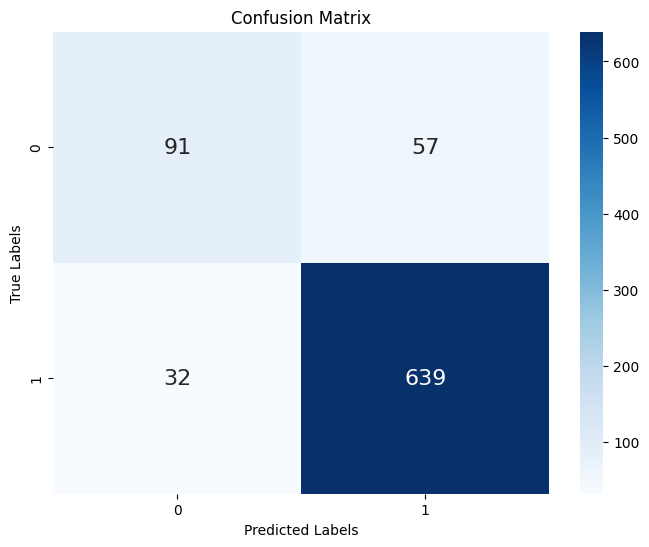

Accuracy on train set:  0.9969437652811736
Accuracy on test set:  0.8913308913308914


In [ ]:
# CountVectorizer V2

# 'Sentiment' includes values of 1 or 0, where 1 is a positive review and 0 is a negative review.
y = df['Sentiment']

# 'Text' contains the written reviews from the users.
X = df['Text']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Use CountVectorizer to convert text data into numerical features
vectorizer = CountVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Inspect the shape of the transformed data
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


# Create a Logistic Regression model
model = LogisticRegression(random_state=42,max_iter=1000)

print(model.head)
# Train the model
model.fit(X_train, y_train)

# Predictions on the test set
y_pred = model.predict(X_test)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using Seaborn and Matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


# Analyze the accuracy
print('Accuracy on train set: ', model.score(X_train, y_train))
print('Accuracy on test set: ', model.score(X_test, y_test))

In [ ]:
# Create lists to store accuracies
train_accuracies = []
test_accuracies = []

# Define the dataset sizes
dataset_sizes = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

# Iterate over dataset sizes
for size in dataset_sizes:
    # Select a subset of the data
    subset_df = df.head(size)

    # Split the data into training and testing sets
    y_subset = subset_df['Sentiment']
    X_subset = subset_df['Text']
    X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

    # Use CountVectorizer to convert text data into numerical features
    vectorizer_subset = CountVectorizer(stop_words='english')
    X_train_subset = vectorizer_subset.fit_transform(X_train_subset)
    X_test_subset = vectorizer_subset.transform(X_test_subset)

    # Create a Logistic Regression model
    model_subset = LogisticRegression(random_state=42, max_iter=1000)

    # Train the model
    model_subset.fit(X_train_subset, y_train_subset)

    # Calculate accuracy on the training set
    train_accuracy = accuracy_score(y_train_subset, model_subset.predict(X_train_subset))
    train_accuracies.append(train_accuracy)

    # Calculate accuracy on the test set
    test_accuracy = accuracy_score(y_test_subset, model_subset.predict(X_test_subset))
    test_accuracies.append(test_accuracy)

# Plot the accuracies
plt.plot(dataset_sizes, train_accuracies, marker='o', label='Training Set')
plt.plot(dataset_sizes, test_accuracies, marker='o', label='Test Set')
plt.title('Accuracy vs Dataset Size')
plt.xlabel('Dataset Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

TypeError: __init__() got an unexpected keyword argument 'stratify'

## CountVectorizer with n-grams

N-grams are contiguous sequences of n items (words, characters, or other units) from a given sample of text or speech.

Unigrams
Unigrams are single words or tokens. For example, in the sentence "Unsupervised machine learning", the unigrams are: "Unsupervised", "machine, and "learning".

Bigrams
Bigrams are pairs of adjacent words. They are created by taking two consecutive words together. For example, in the same sentence the bigrams are: "Unsupervised machine" and "machine learning".

N-grams
N-grams are sequences of 'n' words. They can be any combination of adjacent words in a text. For example, in the same sentence the 3-gram (or trigram) is: "Supervised machine learning".

Only unigrams = default 91%

Only bigrams = 83%

Unigrams + bigrams = 90%

Only trigrams = 81

Unigrams, bigrams and trigrams = 90%

With CountVectorizer the ngrams parameter doesn't improve the accuracy; it only makes it more complex (V3) 90%


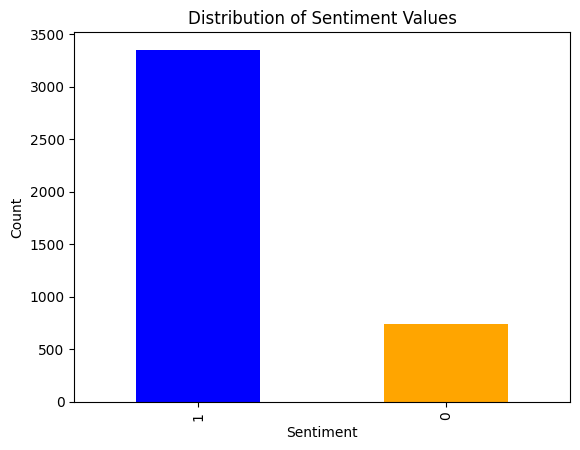

In [ ]:
# Plot the distribution of 'Sentiment' values
df['Sentiment'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Sentiment Values')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

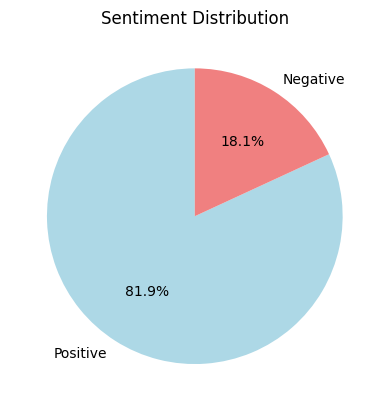

In [ ]:

# Calculate the percentage distribution of 'Sentiment' values
sentiment_distribution = df['Sentiment'].value_counts(normalize=True) * 100

# Plot the distribution using a pie chart
labels = ['Positive', 'Negative']
colors = ['lightblue', 'lightcoral']

plt.pie(sentiment_distribution, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution')
plt.show()

In [ ]:
# CountVectorizer V3

# Define X and y
y = df['Sentiment']

# Assuming 'Text' is the column containing your text data
X = df['Text']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Use CountVectorizer to convert text data into numerical features
vectorizer = CountVectorizer(ngram_range=(1,2), stop_words='english') #include unigrams and bigrams
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Inspect the shape of the transformed data
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

# Create a Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
print('Accuracy on train set: ', model.score(X_train, y_train))
print('Accuracy on test set: ', model.score(X_test, y_test))

Shape of X_train: (3272, 106200)
Shape of X_test: (819, 106200)
Accuracy on train set:  1.0
Accuracy on test set:  0.9010989010989011


## CountVectorizer with  Stemming

Stemming is a text processing technique that involves reducing words to their base or root form, which may not always be a valid word. This is done by removing prefixes or suffixes from words, with the goal of reducing related words to a common base form. For example, "mining" and "mined" would both be stemmed to "mine".

Logistic Regression with stemming includes (V4) 89%


In [ ]:
# Initialize Porter Stemmer
stemmer = PorterStemmer()

# Function to apply stemming to a text
def stemming(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

# Apply stemming to each row in 'Text' column and create a new 'Stemmed_text' column
df['Stemmed_text'] = df['Text'].apply(stemming)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Stemmed_text'], df['Sentiment'], test_size=0.2, random_state=42, stratify=y)

# Create a CountVectorizer with stopwords
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the training data
X_train_transformed = vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_transformed = vectorizer.transform(X_test)

# Inspect the shape of the transformed data
print("Shape of X_train:", X_train_transformed.shape)
print("Shape of X_test:", X_test_transformed.shape)

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_transformed, y_train)

# Make predictions on the training and test sets
train_predictions = model.predict(X_train_transformed)
test_predictions = model.predict(X_test_transformed)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

Shape of X_train: (3272, 9581)
Shape of X_test: (819, 9581)
Training Accuracy: 1.00
Test Accuracy: 0.87


## Logistic Regression with Regularization

Regularization in logistic regression is a technique used to prevent overfitting and improve the generalization performance of the model. Overfitting occurs when a model learns the training data too well, capturing noise and specific patterns that may not generalize well to new, unseen data.

Logistic Regression with regularization includes (V5) 89%


In [ ]:
# CountVectorizer V5

# Define X and y
y = df['Sentiment']

# Assuming 'Text' is the column containing your text data
X = df['Text']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Use CountVectorizer to convert text data into numerical features
vectorizer = CountVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Create a Logistic Regression model
base_model = LogisticRegression(random_state=42)
model1 = LogisticRegression(C=1000, random_state=42, max_iter=2000)
model2 = LogisticRegression(C=100, random_state=42, max_iter=2000)
model3 = LogisticRegression(C=10, random_state=42, max_iter=2000)
model4 = LogisticRegression(C=0.01, random_state=42, max_iter=2000)

# Train the model
base_model.fit(X_train, y_train)
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)
model4.fit(X_train, y_train)


# Make predictions on the test set
base_predictions = base_model.predict(X_test)
predictions1 = model1.predict(X_test)
predictions2 = model2.predict(X_test)
predictions3 = model3.predict(X_test)
predictions4 = model4.predict(X_test)

# Evaluate the model
base_accuracy = accuracy_score(y_test, base_predictions)
accuracy1 = accuracy_score(y_test, predictions1)
accuracy2 = accuracy_score(y_test, predictions2)
accuracy3 = accuracy_score(y_test, predictions3)
accuracy4 = accuracy_score(y_test, predictions4)

print(f'Accuracy of the base model: {base_accuracy}')
print(f"Accuracy of model 1: {accuracy1}")
print(f"Accuracy of model 2: {accuracy2}")
print(f"Accuracy of model 3: {accuracy3}")
print(f"Accuracy of model 4: {accuracy4}")

Accuracy of the base model: 0.8913308913308914
Accuracy of model 1: 0.8620268620268621
Accuracy of model 2: 0.8644688644688645
Accuracy of model 3: 0.8742368742368742
Accuracy of model 4: 0.873015873015873


In [ ]:
# Train a logistic regression with regularization of 1000
log_reg1 = LogisticRegression(C=1000).fit(X_train, y_train)
# Train a logistic regression with regularization of 0.001
log_reg2 = LogisticRegression(C=0.001).fit(X_train, y_train)

# Print the accuracies
print('Accuracy of model 1: ', log_reg1.score(X_test, y_test))
print('Accuracy of model 2: ', log_reg2.score(X_test, y_test))

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Accuracy of model 1:  0.884004884004884
Accuracy of model 2:  0.818070818070818


## max_features parameter

In [ ]:
# Does max_features parameter improve the model?

# Using cross validation to find the optimal value for amount of max_features

max_features_values = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Best values seem to be around 900 features, which will lead to 85% accuracy score. 
# I think 5 % accuracy drop is quite huge, lets see if we need no implement this parameter.

## min_df and max_df parameters

max_df is a parameter that specifies the maximum proportion (or absolute count) of documents in which a term is allowed to appear.

min_df is a parameter that specifies the minimum proportion (or absolute count) of documents in which a term must appear to be considered in the vocabulary.

With values min_df=0.1, max_df=0.7, the accuracy dropped to 86%.

In [ ]:
# Define X and y
y = df['Sentiment']

# Assuming 'Text' is the column containing your text data
X = df['Text']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use CountVectorizer to convert text data into numerical features
vectorizer = CountVectorizer(stop_words='english', min_df=0.1, max_df=0.7)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Create a Logistic Regression model
model = LogisticRegression(random_state=42,max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8559218559218559


/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

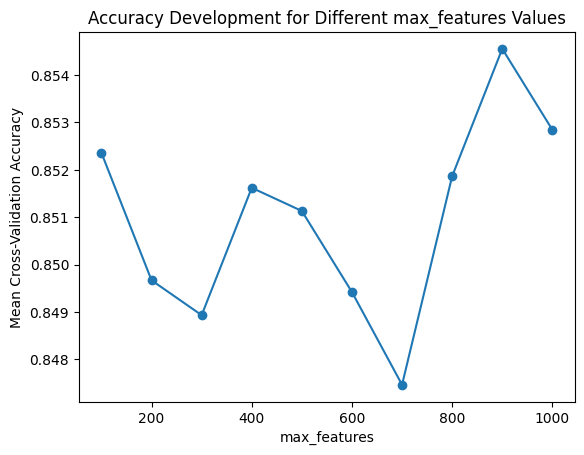

In [ ]:
# Initialize an empty list to store mean cross-validation scores
mean_cv_scores = []

# Use cross-validation to evaluate the model for each max_features value
for max_features in max_features_values:
    vectorizer = CountVectorizer(max_features=max_features)
    X_vectorized = vectorizer.fit_transform(X)
    
    # LogisticRegression model
    model = LogisticRegression(random_state=42)
    
    # Perform cross-validation and store the mean accuracy
    cv_scores = cross_val_score(model, X_vectorized, y, cv=5, scoring='accuracy')
    mean_cv_scores.append(np.mean(cv_scores))

# Plot the results
plt.plot(max_features_values, mean_cv_scores, marker='o')
plt.title('Accuracy Development for Different max_features Values')
plt.xlabel('max_features')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ba51830b-6fc6-477d-b787-3109e774d6c1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>